In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy.stats as scis

## Figure recreation

### Classes and functions

In [2]:
#Network nodes
class MetNode:
    def __init__(self, name, essential):
        self.name = name
        self.essential = essential
        self.between_centrality = 0
        self.bridging_coefficient = 0
        self.bridging_centrality = 0
        self.cascade_set = None
        self.cascade_number = 0
        self.in_edges = None
        self.in_out = None
    
    def find_in_edges(self, edges):
        self.in_edges = [x for x in edges if x[1] == self.name]
        
    def find_out_edges(self, edges):
        self.out_edges = [x for x in edges if x[0] == self.name]

In [3]:
#Builds edges from adjacency matrix, disgustingly O(n^2), sorry
def build_network(adjacency_matrix):
    edges = []
    for row in adjacency_matrix.index:
        for col in adjacency_matrix.columns:
            if adjacency_matrix.at[row, col]:
                new_edge = (row.strip(), col.strip())
                edges.append(new_edge)
    return edges

In [4]:
#read in essential functions, calculated in MatLab using FBA in COBRA toolbox
def read_essential(filename):
    essential_nodes = []
    with open(filename, 'r') as f:
        essential_nodes = f.read().splitlines()
    return essential_nodes

#### Centrality metrics

In [5]:
"""
The betweenness centrality of a node is the fraction of shortest 
paths from all nodes to all others that pass through the 
particular node.

B(i) = sum(j != k != i) sigma_jk(i)/sigma_jk

where sigma_jk is the total number of shortest paths from node j to node k
sigma_jk(i) total number of those paths that pass through node i

Implementation taken from Brandes, Ulrik (2001). "A faster 
algorithm for betweenness centrality", Journal of
Mathematical Sociology. 25 (2): 163–177
"""  

def betweenness_centrality(all_nodes):
    bcs = {} #empty dictionary, will hold betcens
    for s in all_nodes.values():
        bcs[s] = 0 #initalize all to 0
    for j in all_nodes.values():
        S = [] #empty stack
        P = {}
        sigma = {}
        d = {}
        delta = {}
        for k in all_nodes.values():
            P[k] = [] #empty list
            sigma[k] = 0
            d[k] = -1
            delta[k] = 0 #delta[v] <- 0 for v in V
        sigma[j] = 1 #sigma[s] <- 1
        d[j] = 0 #d[s] <- 0
        Q = [] # empty queue
        Q.append(j) #enqueue s -> Q
        while Q:
            v = Q[0] # dequeue v <- Q
            Q.remove(v)
            S.append(v) #push v -> S
            for w in [all_nodes[x[1]] for x in v.out_edges]:
                if d[w] < 0:
                    Q.append(w) #enqueue w -> Q
                    d[w] = d[v] + 1 #update distance
                if d[w] == (d[v] + 1):
                    sigma[w] += sigma[v]
                    P[w].append(v) #append v -> P[w]
        while S:
            w = S[-1] # pop w <- S
            S.remove(w)
            for v in P[w]:
                delta[v] += (sigma[v]/sigma[w])*(1+delta[w])
            if w != j:
                bcs[w] += delta[w]
    return bcs

In [6]:
#degree_total(i)^-1/ sum of total degrees of neighbors^-1
def bridging_coefficient(node, all_nodes):
    if len(node.in_edges) == 0 and len(node.out_edges) == 0:
        return 0
    num = total_degree(node)**-1
    denom = 0
    for neighbor in get_neighborhood(node, all_nodes):
        denom += total_degree(neighbor)**-1
    return num/denom
        
def total_degree(node):
    return len(node.in_edges) + len(node.out_edges)

def get_neighborhood(node, all_nodes):
    return set([all_nodes[edge[1]] for edge in node.out_edges] \
        + [all_nodes[edge[0]] for edge in node.in_edges])

In [7]:
def cascade_set(node, all_nodes):
    start_node = node
    cutoff = {}
    for v in all_nodes.values():
        cutoff[v] = 0
    queue = [] #initialize a queue with the Node
    cutoff[node] = 1 #mark node as cut off
    # add all nodes v for which (Node, v) in A to the queue
    queue += [all_nodes[edge[1]] for edge in node.out_edges]
    for q in queue:
        if all([cutoff[all_nodes[edge[0]]] for edge in q.in_edges]):
           cutoff[q] = 1
           queue += [all_nodes[edge[1]] for edge in q.out_edges]
    cascade_set = [node for node in cutoff.keys() if cutoff[node]]
    cascade_set.remove(start_node)    
    return cascade_set

In [8]:
#C(i) = n_i/(k_i * (k_i - 1))
#n_i is the number of arcs between neighborhood of the node i
#k_i is the number of neighbors of node i
def clustering_coefficient(node, all_nodes):
    neighborhood = get_neighborhood(node, all_nodes)
    k_i = len(neighborhood)
    n_i = 0
    for j in neighborhood:
        for k in neighborhood:
            if j != k:
                if (j.name, k.name) in j.out_edges:
                    n_i +=1
    if k_i == 0 or k_i == 1:
        return 0.1
    return n_i/(k_i * (k_i - 1))

#### Functions to plot

In [9]:
#bin by metrics
def bin_nodes(nodes, inds, bins):
    bc_bins = {}
    for i in range(len(inds)):
        bin_index = inds[i] 
        if bin_index >= len(bins):
            bin_index = len(bins) - 1
        node_bin = bins[bin_index]
        if node_bin in bc_bins.keys():
            bc_bins[node_bin].append(nodes[i])
        else:
            bc_bins[node_bin] = [nodes[i]]
    return bc_bins

def log10(val):
    if val == 0:
        return 0
    return math.log10(val)

In [10]:
def count_essential(bins):
#calculate number + fraction of essential reactions
    x = []
    y = []
    unessential = []
    essential = []
    for key, val in sorted(bins.items(), key = lambda x: x[0]):
        x.append(key)
        y.append(100*sum([node.essential for node in val])/len(val))
        essential.append(sum([node.essential for node in val]))
        unessential.append(len(val) - essential[-1])
    return x, y, essential, unessential

In [11]:
def fig3plot(x, y, essential, unessential, x_title, x_min, x_max, x_step, x_width, r_x, r_y, title = None):
    #use all the data to generate the figure
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(x_title)
    ax1.set_xticks(np.arange(x_min, x_max, x_step))
    ax1.set_ylabel('Number of reactions')
    ax1.bar(x, essential, x_width, color = 'black')
    ax1.bar(x, unessential, x_width, bottom=essential, color = 'darkgray')

    #linear regression
    slope, intercept, r, p, stderr = scis.linregress(x, y)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel("% Essential reactions")
    ax2.scatter(x, y, color = 'black')
    x_lin = np.linspace(0, max(x), 18)
    y_lin = intercept + slope*x_lin
    ax2.plot(x_lin, y_lin, color='black')

    r_text = "r = {:0.2f}".format(r)
    ax2.text(r_x, r_y, r_text)
    
    if title:
        plt.title(title)
    
    fig.tight_layout()
    plt.show()
    
    return fig

### Read in data and build network

#### Test on toy graph (Fig 1)

In [12]:
testEdges = [('1', '2'), ('1', '3'), ('1', '4'), ('2', '4'),
             ('3', '4'), ('4', '5'),('5', '6'),('6', '7'),('7', '6')]

testNodes = {}
for i in range(1,8):
    newNode = MetNode(str(i), False) #essential doesn't matter here
    newNode.find_in_edges(testEdges)
    newNode.find_out_edges(testEdges)
    testNodes[str(i)] = newNode

In [13]:
#calculate and update centrality metrics
test_bcs = betweenness_centrality(testNodes) 
for node, val in test_bcs.items():
    node.between_centrality = val
    node.bridging_coefficient = bridging_coefficient(node, testNodes)
    node.bridging_centrality = node.between_centrality * node.bridging_coefficient
    node.cascade_number = len(cascade_set(node, testNodes))

In [14]:
#compare against knowns (Table 2)
table_2_vals = [[3, 2, 2, 4, 2, 3, 2],
                [0, 0, 0, 9, 8, 5, 0],
                ['0.2667', '0.8571', '0.8571', '0.1364', '0.8571', '0.3333', '1.5000'],
                [0, 0, 0, 1.2273, 6.8571, 1.6667, 0],
                [4, 0, 0, 1, 0, 1, 0]]

degrees = []
BCs = []
Brs = []
BrCs = []
C_numbers = []
for key in sorted(testNodes.keys()):
    node = testNodes[key]
    degrees.append(total_degree(node))
    BCs.append(node.between_centrality)
    #rounding + string conversion to get around imperfect float representation
    Brs.append("{0:.4f}".format(round(node.bridging_coefficient/ 0.0001) * 0.0001)) 
    BrCs.append(round(node.bridging_centrality/ 0.0001) * 0.0001)
    C_numbers.append(node.cascade_number)
    
table_2_vals == [degrees, BCs, Brs, BrCs, C_numbers]

True

#### Generate figures with actual data 

In [15]:
#automatically reads 1st sheet, which is E. coli
adjacency_matrix = pd.read_excel('12859_2019_2897_MOESM2_ESM.xlsx', index_col=0)

In [16]:
#construct network from adjacency matrix
am_arcs = build_network(adjacency_matrix)
unique_nodes = set([x[0] for x in am_arcs] + [x[1] for x in am_arcs])

In [17]:
essential_nodes = read_essential('le0.05_essential_rxns.txt')

In [18]:
#build all reaction nodes, set edges + essential
metNodes = {}
for node in unique_nodes:
    newNode = MetNode(node, node in essential_nodes)
    newNode.find_in_edges(am_arcs)
    newNode.find_out_edges(am_arcs)
    metNodes[node] = newNode #for constant access

In [19]:
sum([node.essential for node in metNodes.values()])

241

In [20]:
#calculate and update centrality metrics
met_bcs = betweenness_centrality(metNodes)
for node, val in met_bcs.items():
    node.between_centrality = val
    node.bridging_coefficient = bridging_coefficient(node, metNodes)
    node.bridging_centrality = node.between_centrality * node.bridging_coefficient
    node.clustering_coefficient = clustering_coefficient(node, metNodes)

In [21]:
sorted_nodes = sorted(list(metNodes.values()), key=lambda x: x.name)
inds = np.digitize([log10(node.bridging_centrality) for node in sorted_nodes], np.arange(0.0, 5.0, 0.5))
a = bin_nodes(sorted_nodes,
        np.digitize([log10(node.bridging_centrality) for node in sorted_nodes], 
        np.arange(0.0, 5.0, 0.5), right=True), np.arange(0.0, 5.0, 0.5))
b = bin_nodes(sorted_nodes, 
        np.digitize([log10(node.between_centrality) for node in sorted_nodes], 
        np.arange(0.0, 5.5, 0.5), right = True), np.arange(0.0, 5.5, 0.5))
c = bin_nodes(sorted_nodes, 
        np.digitize([node.clustering_coefficient for node in sorted_nodes], 
        np.arange(0.1, 1.1, 0.1), right = True), np.arange(0.1, 1.1, 0.1))
d = bin_nodes(sorted_nodes, 
        np.digitize([log10(total_degree(node)) for node in sorted_nodes], 
        np.arange(0.25, 2.50, 0.25), right = True), np.arange(0.25, 2.50, 0.25))

In [22]:
x, y, e, u = count_essential(a)

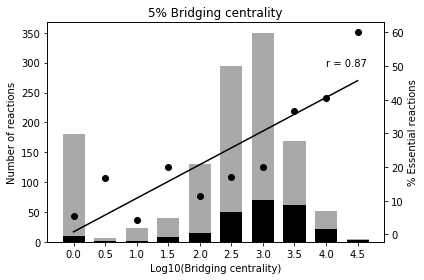

In [23]:
fig = fig3plot(x, y, e, u, "Log10(Bridging centrality)", 
         0, 5.0, 0.5, 0.35, 4.0, 50, title="5% Bridging centrality")
fig.savefig('3a.png', bbox_inches='tight', dpi=200)

In [24]:
x2, y2, e2, u2 = count_essential(b)

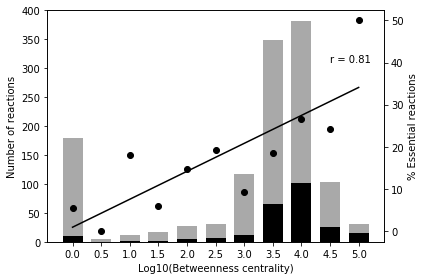

In [25]:
fig = fig3plot(x2, y2, e2, u2, "Log10(Betweenness centrality)", 
         0, 5.5, 0.5, 0.35, 4.5, 40)
fig.savefig('3b.png', bbox_inches='tight', dpi=200)

In [26]:
x3, y3, e3, u3 = count_essential(c)

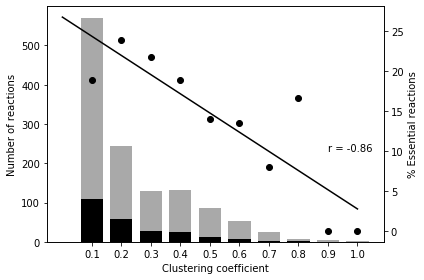

In [27]:
fig = fig3plot(x3, y3, e3, u3, "Clustering coefficient", 
         0.1, 1.1, 0.1, 0.075, 0.9, 10)
fig.savefig('3c.png', bbox_inches='tight', dpi=200)

In [28]:
x4, y4, e4, u4 = count_essential(d)

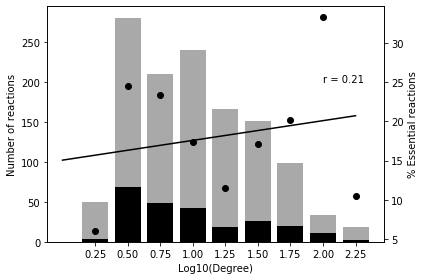

In [29]:
fig = fig3plot(x4, y4, e4, u4, "Log10(Degree)", 
         0.25, 2.50, 0.25, 0.2, 2.00, 25)
fig.savefig('3d.png', bbox_inches='tight', dpi=200)

### Sensitivity testing

#### cutoff = 0.5 * max_growth

In [30]:
#read in new essential reactions and reassign
higher_cutoff = read_essential('le0.5_essential_rxns.txt')

for node in metNodes.values():
    node.essential = node.name in higher_cutoff

sum([node.essential for node in metNodes.values()])

242

In [31]:
#recalculale % and plot
x, y, e, u = count_essential(a)

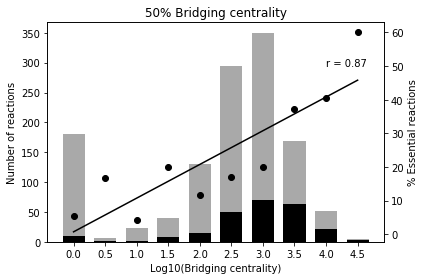

In [32]:
fig = fig3plot(x, y, e, u, "Log10(Bridging centrality)", 
         0, 5.0, 0.5, 0.35, 4.0, 50, title="50% Bridging centrality")
fig.savefig('3a_0.5.png', bbox_inches='tight', dpi=200)

In [33]:
x3, y3, e3, u3 = count_essential(c)

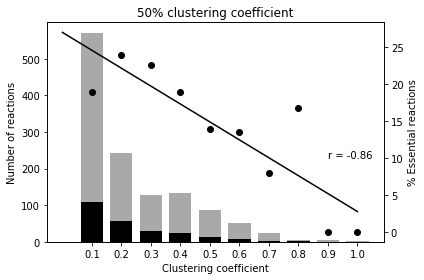

In [34]:
fig = fig3plot(x3, y3, e3, u3, "Clustering coefficient", 
         0.1, 1.1, 0.1, 0.075, 0.9, 10, title="50% clustering coefficient")
fig.savefig('3c_0.5.png', bbox_inches='tight', dpi=200)

##### cutoff = 1.0 * max_growth

In [35]:
#read in new essential reactions and reassign
any_decrease = read_essential('l1_essential_rxns.txt')

for node in metNodes.values():
    node.essential = node.name in any_decrease

sum([node.essential for node in metNodes.values()])

610

In [36]:
#recalculale % and plot
x, y, e, u = count_essential(a)

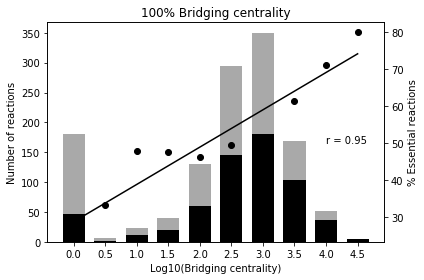

In [37]:
fig = fig3plot(x, y, e, u, "Log10(Bridging centrality)", 
         0, 5.0, 0.5, 0.35, 4.0, 50, title="100% Bridging centrality")
fig.savefig('3a_1.0.png', bbox_inches='tight', dpi=200)

In [38]:
x3, y3, e3, u3 = count_essential(c)

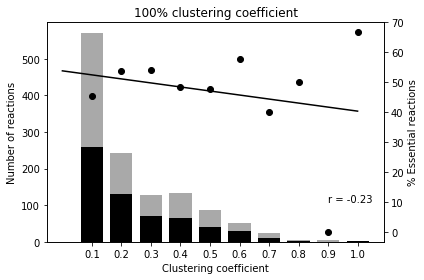

In [39]:
fig = fig3plot(x3, y3, e3, u3, "Clustering coefficient", 
         0.1, 1.1, 0.1, 0.075, 0.9, 10, title="100% clustering coefficient")
fig.savefig('3c_1.0.png', bbox_inches='tight', dpi=200)

##### cutoff = 0.0 * max_growth

In [40]:
#read in new essential reactions and reassign
any_decrease = read_essential('e0_essential_rxns.txt')

for node in metNodes.values():
    node.essential = node.name in any_decrease

sum([node.essential for node in metNodes.values()])

172

In [41]:
#recalculale % and plot
x, y, e, u = count_essential(a)

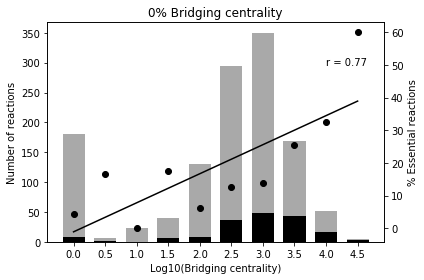

In [42]:
fig = fig3plot(x, y, e, u, "Log10(Bridging centrality)", 
         0, 5.0, 0.5, 0.35, 4.0, 50, title="0% Bridging centrality")
fig.savefig('3a_0.0.png', bbox_inches='tight', dpi=200)

In [43]:
x3, y3, e3, u3 = count_essential(c)

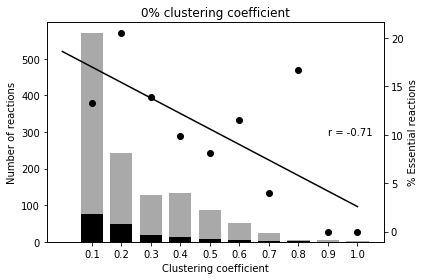

In [44]:
fig = fig3plot(x3, y3, e3, u3, "Clustering coefficient", 
         0.1, 1.1, 0.1, 0.075, 0.9, 10, title="0% clustering coefficient")
fig.savefig('3c_0.0.png', bbox_inches='tight', dpi=200)